# S-parameter extraction

One thing you might be interested in using MEEP for is to obtain the S-parameters (transmission, reflection, etc.) of your device.

Back to last Notebook's directional coupler :

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

In [2]:
res = 50        # pixels/μm
three_d = False # 3d calculation?
d = 0.12        # branch separation

gdsII_file = 'bend_zeropdk.gds'
CELL_LAYER = 0
SOURCE_LAYER = 10
UPPER_BRANCH_LAYER = 1

t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

dpml = 1
cell_thickness = dpml+t_oxide+t_Si+t_air+dpml
si_zmin = 0

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

cell_zmax =  0
cell_zmin =  0
si_zmax = 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
upper_branch = mp.get_GDSII_prisms(silicon, gdsII_file, UPPER_BRANCH_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)

Now declare simulation :

In [9]:
geometry = upper_branch

sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.EVEN_Y+mp.ODD_Z,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    eps_averaging=False,
                    subpixel_maxeval=1,
                    subpixel_tol=1,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=geometry,
                    geometry_center=mp.Vector3(4, -1*4))

In [10]:
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000345945 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
     prism, center = (3.16414,-1.83585,0)
          height 0, axis (0,0,1), 132 vertices:
          (4.75,-5,0)
          (4.749,-4.883,0)
          (4.744,-4.767,0)
          (4.737,-4.651,0)
          (4.727,-4.534,0)
          (4.714,-4.419,0)
          (4.699,-4.303,0)
          (4.68,-4.188,0)
          (4.659,-4.073,0)
          (4.635,-3.959,0)
          (4.608,-3.846,0)
          (4.578,-3.733,0)
          (4.545,-3.621,0)
          (4.51,-3.51,0)
          (4.472,-3.4,0)
          (4.432,-3.291,0)
          (4.388,-3.182,0)
          (4.342,-3.075,0)
          (4.294,-2.969,0)
          (4.243,-2.864,0)
          (4.189,-2.761,0)
          (4.133,-2.659,0)
          (4.074,-2.558,0)
          (4.013,-2.459,0)
          (3.949,-2.361,0)
          (3.884,-2.265,0)
          (3.815,-2.17,0)
          (3.745,-2.078,0)
  

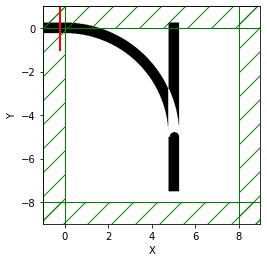

In [11]:
sim.plot2D()

We also add monitors at each port; these will record the field at a specific location, allowing us to compute ratios and hence S-parameters :

In [6]:
mode1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p2))
mode3 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p3))
mode4 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p4))

Run simulation (long enough for time not to affect results) :

In [7]:
sim.run(until_after_sources=100)  # We run with a different option, only for some delay after sources are off

-----------
Initializing structure...
time for choose_chunkdivision = 0.000507832 s
Working in 2D dimensions.
Computational cell is 34.4 x 8 x 0 with resolution 50
     prism, center = (-9.09425,1.41149,0)
          height 0, axis (0,0,1), 174 vertices:
          (-4,0.15,0)
          (-4.108,0.151,0)
          (-4.215,0.152,0)
          (-4.322,0.155,0)
          (-4.429,0.16,0)
          (-4.535,0.165,0)
          (-4.641,0.171,0)
          (-4.747,0.179,0)
          (-4.852,0.187,0)
          (-5.062,0.207,0)
          (-5.167,0.219,0)
          (-5.271,0.231,0)
          (-5.479,0.259,0)
          (-5.582,0.274,0)
          (-5.685,0.29,0)
          (-5.788,0.307,0)
          (-5.891,0.325,0)
          (-5.993,0.343,0)
          (-6.095,0.362,0)
          (-6.197,0.382,0)
          (-6.299,0.403,0)
          (-6.4,0.424,0)
          (-6.501,0.446,0)
          (-6.703,0.492,0)
          (-6.803,0.515,0)
          (-6.904,0.54,0)
          (-7.204,0.615,0)
          (-7.303,0.642,0)


Use the monitors to extract S-parameters :

In [11]:
# S parameters
p1_coeff = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.EVEN_Y+mp.ODD_Z).alpha[0,0,0]
p2_coeff = sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.EVEN_Y+mp.ODD_Z).alpha[0,0,0]
p3_coeff = sim.get_eigenmode_coefficients(mode3, [1], eig_parity=mp.EVEN_Y+mp.ODD_Z).alpha[0,0,0]
p4_coeff = sim.get_eigenmode_coefficients(mode4, [1], eig_parity=mp.EVEN_Y+mp.ODD_Z).alpha[0,0,0]

# transmittance
p2_trans = abs(p2_coeff)**2/abs(p1_coeff)**2
p3_trans = abs(p3_coeff)**2/abs(p1_coeff)**2
p4_trans = abs(p4_coeff)**2/abs(p1_coeff)**2

print("trans:, {:.2f}, {:.6f}, {:.6f}, {:.6f}".format(d,p2_trans,p3_trans,p4_trans))

MPB solved for omega_1(2.2349,0,0) = 0.684048 after 10 iters
MPB solved for omega_1(2.09576,0,0) = 0.645197 after 7 iters
MPB solved for omega_1(2.09563,0,0) = 0.645161 after 4 iters
MPB solved for omega_1(2.09563,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.095628,-0.000000,0.000000)
MPB solved for omega_1(2.2349,0,0) = 0.684048 after 11 iters
MPB solved for omega_1(2.09576,0,0) = 0.645197 after 7 iters
MPB solved for omega_1(2.09563,0,0) = 0.645161 after 4 iters
MPB solved for omega_1(2.09563,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.095628,-0.000000,0.000000)
MPB solved for omega_1(2.2349,0,0) = 0.684048 after 11 iters
MPB solved for omega_1(2.09576,0,0) = 0.645197 after 7 iters
MPB solved for omega_1(2.09563,0,0) = 0.645161 after 4 iters
MPB solved for omega_1(2.09563,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.095628,-0.000000,0.000000)
MPB solved for omega_1(2.2349,0,0) = 0.684048 after 10 iters
MPB solved for omega_1(2

You could verify this for different spacings between the branches, different wavelengths, different waveguides, etc.